In [41]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision

In [42]:
learning_rate = 0.01
batch_size = 64
epochs = 50
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

import os
train_data = torchvision.datasets.CIFAR10(
    root=os.getcwd(), train=True, download=True,
    transform=torchvision.transforms.ToTensor()
)
test_data = torchvision.datasets.CIFAR10(
    root=os.getcwd(), train=False, download=True,
    transform=torchvision.transforms.ToTensor()
)
train_data.data.shape, len(train_data.targets)
print("Train data: ",len(train_data))
print("Test data: ",len(test_data))

Files already downloaded and verified
Files already downloaded and verified
Train data:  50000
Test data:  10000


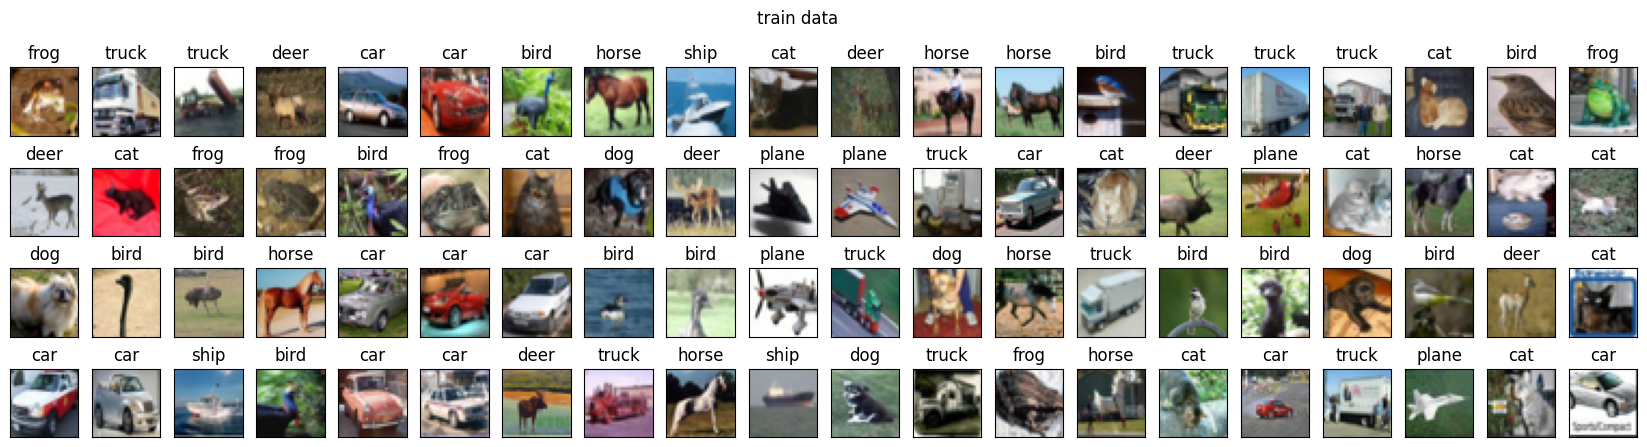

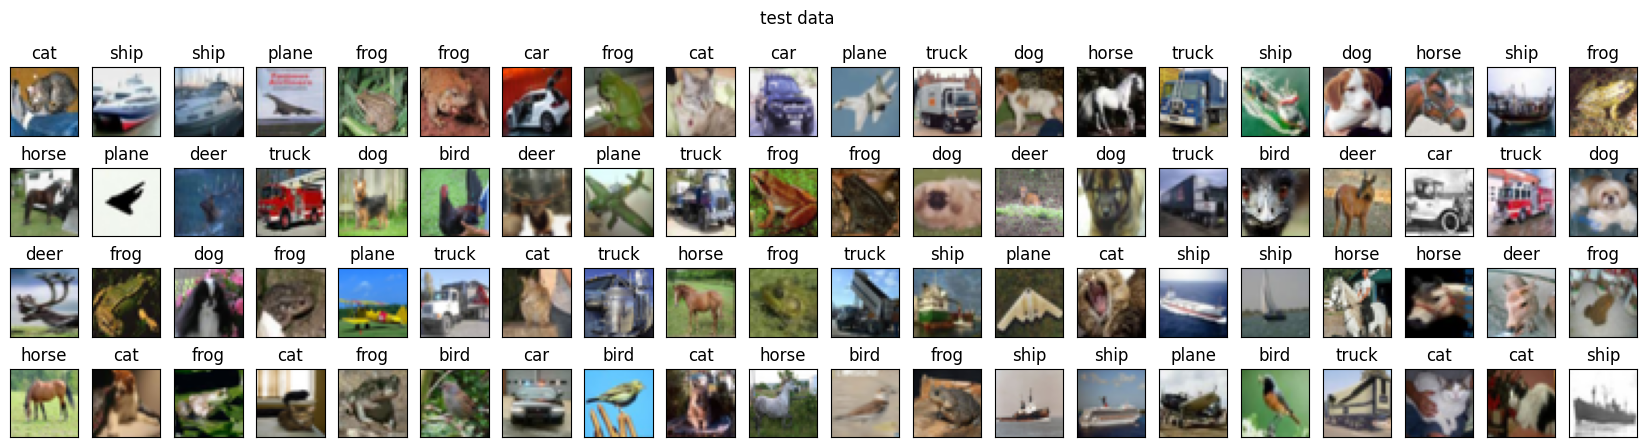

In [43]:
def show_images(images: list, labels: list, rows, cols, title=None):
    fig, ax = plt.subplots(rows, cols, figsize=(21,5))
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    for i, ax in enumerate(fig.axes):
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])

show_images(train_data.data, train_data.targets, 4, 20, title="train data")
show_images(test_data.data, test_data.targets, 4, 20, title="test data")

In [44]:
import torch
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [45]:
import torch.nn as nn
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet34(num_classes=1000):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)


In [46]:
resnet = ResNet34(num_classes=len(classes))
optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate)
loss_func = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [47]:
def calc_accuracy(dataLoader, model):
  tp = 0
  n = 0
  with torch.no_grad():
    for images, labels in dataLoader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        n += labels.size(dim=0)
        tp += (predicted == labels).sum()
    return tp / n

def calc_loss(dataLoader, model):
  loss = 0
  n = 0
  with torch.no_grad():
      for images, labels in dataLoader:
          labels = labels.to(device)
          images = images.to(device)
          outputs = model(images)
          loss += loss_func(outputs, labels)
          n += labels.size(0)
  return loss / n

In [48]:
def train(model, data, epochs, loss_func, optimizer):
  start = time.time()
  loss_graph = []
  accuracy_graph = []
  for epoch in range(epochs):
    epoch_start = time.time()
    loss_epoch = []
    accuracy_epoch = []
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss_epoch.append(loss)
        accuracy_epoch.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))

        loss.backward()
        optimizer.step()

    loss_graph.append(torch.stack(loss_epoch).mean().cpu().detach().numpy())
    accuracy_graph.append(torch.stack(accuracy_epoch).mean().cpu().detach().numpy())

    print("Epoch ", epoch + 1, " accuracy = {:.3f}".format(torch.stack(accuracy_epoch).mean()),
          ", loss = {:.3f}".format(torch.stack(loss_epoch).mean()), ", time elapsed = {:.3f}".format(time.time() - epoch_start))
  print("total time elapsed: {:.3f}".format((time.time() - start) / 60), "mins")

  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].plot(loss_graph)
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Train loss")
  ax[0].grid()
  ax[1].plot(accuracy_graph)
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Train accuracy")
  ax[1].grid()
  plt.show()

Epoch  1  accuracy = 0.264 , loss = 2.033 , time elapsed = 26.824
Epoch  2  accuracy = 0.459 , loss = 1.461 , time elapsed = 27.143
Epoch  3  accuracy = 0.565 , loss = 1.211 , time elapsed = 27.062
Epoch  4  accuracy = 0.624 , loss = 1.056 , time elapsed = 27.060
Epoch  5  accuracy = 0.640 , loss = 1.021 , time elapsed = 27.515
Epoch  6  accuracy = 0.694 , loss = 0.875 , time elapsed = 27.205
Epoch  7  accuracy = 0.742 , loss = 0.742 , time elapsed = 27.091
Epoch  8  accuracy = 0.777 , loss = 0.644 , time elapsed = 27.175
Epoch  9  accuracy = 0.802 , loss = 0.569 , time elapsed = 27.332
Epoch  10  accuracy = 0.826 , loss = 0.501 , time elapsed = 27.076
Epoch  11  accuracy = 0.851 , loss = 0.431 , time elapsed = 27.109
Epoch  12  accuracy = 0.874 , loss = 0.368 , time elapsed = 27.088
Epoch  13  accuracy = 0.889 , loss = 0.321 , time elapsed = 27.277
Epoch  14  accuracy = 0.908 , loss = 0.269 , time elapsed = 27.088
Epoch  15  accuracy = 0.920 , loss = 0.232 , time elapsed = 27.061
Epoc

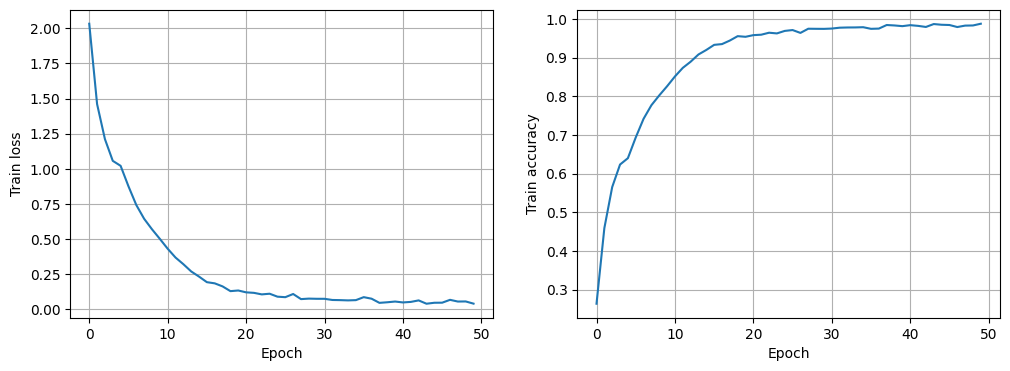

Test data loss: 0.025
Test data accuracy: 0.750


In [49]:
train(resnet, train_data_loader, epochs, loss_func, optimizer)
print("Test data loss: {:.3f}".format(calc_loss(test_data_loader, resnet)))
print("Test data accuracy: {:.3f}".format(calc_accuracy(test_data_loader, resnet)))